In [2]:
# External
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import importlib

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
module_path = os.path.abspath(os.path.join('..'))
module_path, os.getcwd()

('D:\\coding\\dam\\hw230k\\hw2', 'D:\\coding\\dam\\hw230k\\hw2\\code')

In [4]:
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)
if module_path != os.getcwd():
    print(f"""
Changing directory from:
    {os.getcwd()} 
to: 
    {module_path}
"""
         )
    os.chdir(module_path)

Adding D:\coding\dam\hw230k\hw2 to sys.path

Changing directory from:
    D:\coding\dam\hw230k\hw2\code 
to: 
    D:\coding\dam\hw230k\hw2



In [6]:
# Internal
from utils import sql_manager
import hw2_solution

In [7]:
importlib.reload(sql_manager);
importlib.reload(hw2_solution);

In [8]:
sql = sql_manager.ManagerSQL()

D:\coding\dam\hw230k\hw2


## Question 1

### (a) 

Complete the following items for Jan 2020 only.

#### i. 

Plot  a  histogram  of  the  following  factor  exposures:   Beta,  Size,  B/P,  Mo-mentum  and  Variance  (beta,  size,  bm,  mom,  vol  in  the  data).   Computedescriptive statistics for each and present in a table.  Do you think any factor exposure needs a transformation? If so, explain why and apply the trans-formation(s).

In [7]:
# Date
date = datetime(2020, 1, 31)
date_str = date.strftime('%Y-%m-%d')

# Get raw factors and compute weight
raw_factors = sql.select_query(f"select * from crsp_monthly_returns_factors where date='{date_str}'")
raw_factors['weight'] = raw_factors['size'] / raw_factors['size'].sum()
raw_factors.head()

,permno,date,ticker,logret,logret_1m,beta,bm,size,mom,vol,weight
0,17700,2020-01-31,CDAY,-0.020795,-0.035554,NaN,0.261,10552148,0.513727,NaN,0.000335
1,14593,2020-01-31,AAPL,-0.045352,-0.121795,1.257928,0.097,1354254859,0.589887,0.015551,0.043000
2,10107,2020-01-31,MSFT,-0.014869,-0.046772,1.139168,0.100,1294777381,0.408436,0.014303,0.041111
3,84788,2020-01-31,AMZN,0.071195,-0.064235,1.587513,0.066,999960888,0.100930,0.017918,0.031750
4,13407,2020-01-31,FB,-0.037045,-0.047882,0.999401,0.185,485744175,0.310807,0.017948,0.015423


In [8]:
raw_factors.describe()

,permno,logret,logret_1m,beta,bm,size,mom,vol,weight
count,2000.000000,2000.000000,1994.000000,1698.000000,2000.000000,2.000000e+03,1931.000000,1657.000000,2000.000000
mean,51317.083000,-0.021026,-0.097236,1.145897,0.510854,1.574720e+07,0.144971,0.021137,0.000500
std,32510.457528,0.022328,0.118177,0.531239,0.528970,6.069044e+07,0.317288,0.008957,0.001927
min,10026.000000,-0.242593,-1.360976,-0.397382,0.001000,5.007700e+05,-1.509185,0.008926,0.000016
25%,16503.500000,-0.030754,-0.148082,0.803357,0.187750,1.233466e+06,0.006984,0.015069,0.000039
50%,53211.000000,-0.020889,-0.099497,1.113700,0.391000,2.844835e+06,0.150646,0.018532,0.000090
75%,84610.500000,-0.011122,-0.044939,1.444651,0.703250,9.066776e+06,0.302015,0.024801,0.000288
max,93436.000000,0.419628,0.743353,3.270348,9.104000,1.354255e+09,2.518360,0.074980,0.043000


In [9]:
factors = ['beta', 'bm', 'size', 'mom', 'vol']
factors_to_standardize = ['bm', 'size', 'mom', 'vol']
factors_to_log = ['bm', 'size', 'vol']

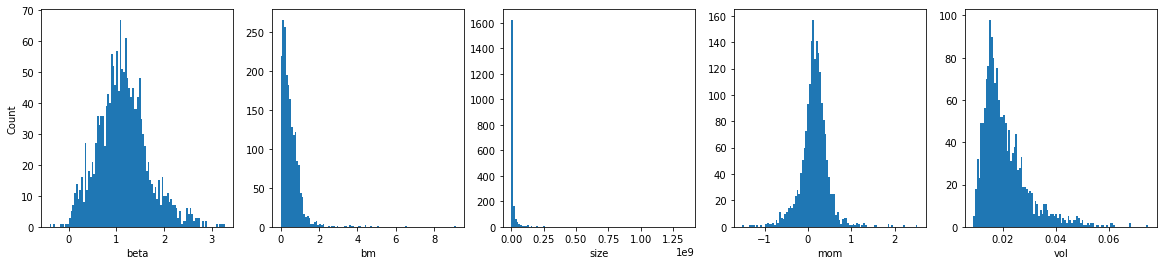

In [51]:
hw2_solution.plot_histogram(raw_factors, factors)

In [11]:
# Log bm, size and vol
df_factors = raw_factors.dropna()
for factor in factors_to_log:
    df_factors[factor] = np.log(df_factors[factor])

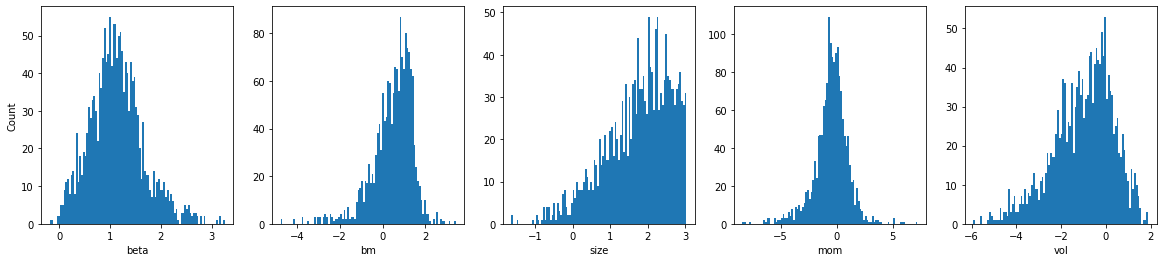

In [52]:
hw2_solution.plot_histogram(df_factors, factors)

There is some level of interpretation here, but at the very least it should be noticed that size is **extremely** skewed to the right. Taking logs is called for. After taking logarithm the distribution looks more normal (an assumption of linear regression), albeit cut off because of the design choice of dealing with only the largest 2000 companies at each month-end (otherwise it would in fact have looked more symmetric). The bm factor and vol are also skewed to the right. I find it reasonable to apply logs here as well to make the distribution more symmetrical.

### ii

Standardize  Size,  Value,  Momentum  and  Volatility.   That  is,  subtract  theweighted mean and divide by the weighted standard deviation over the cross-section for each date.  The weights of a stock on a date is the size of the stockdivided by the size of all stocks on that date.  We will use this same weightsfor computing the regressions afterwards.

In [13]:
# Standardize
for factor in factors_to_standardize:
    mu = np.average(df_factors[factor], weights=df_factors.weight)
    sigma = np.sqrt(np.average((df_factors[factor] - mu)**2, weights=df_factors.weight))
    df_factors[factor] = (df_factors[factor] - mu)/sigma

In [14]:
# Validate
for factor in factors_to_standardize:
    mu = np.average(df_factors[factor], weights=df_factors.weight)
    sigma = np.sqrt(np.average((df_factors[factor] - mu)**2, weights=df_factors.weight))
    print(factor, mu, sigma)

bm 1.8525820099944499e-16 1.0
size -6.683825290960368e-16 0.9999999999999999
mom -1.0171038486244038e-16 0.9999999999999999
vol -6.756475565862111e-16 0.9999999999999999


### iii

Without changing the dispersion of Beta, make the weighted mean equal to 1. What is the advantage of doing this?

In [15]:
factor = 'beta'
mu = np.average(df_factors[factor], weights=df_factors.weight)
df_factors[factor] = df_factors[factor] - (mu - 1)
mu

1.0125910551771744

In [16]:
np.average(df_factors[factor], weights=df_factors.weight)

0.9999999999999998

The expected weighted beta should be equal to 1 (weights proportional to size), as that would be the beta of the market portfolio. Alternatively, you can note that the factor return multiplying beta is the market return and thus:

$$ r_i = r_m \cdot beta + r_{size} \cdot size + r_{bm} \cdot bm + r_{mom} \cdot mom + r_{vol} \cdot vol + \varepsilon $$

Then

$$ E_w(r_i) = r_m E_w(beta) + 0 $$

Since we have standardized size, bm, mom, and vol. I.e. 

$$ E_w(size) = E_w(bm) = E_w(mom) = E_w(vol) = 0 $$

However, we can note that E_w(r_i) = r_m (with r_m the expected return of the market). Hence,
$E_w(beta)$ should be equal to 1 (assuming portfolio arithmetic is approximately right using log returns). And it was already very close to 1 to start with.

### iv

Run the cross-sectional regression of the mentioned date in order to get the factor returns. Using \emph{statsmodels} get the summary statistics of the run and comment results.

In [17]:
date = datetime(2020, 1, 31)
date_str = date.strftime('%Y-%m-%d')

In [53]:
factors_to_log = ['bm', 'size', 'vol']
factors_to_standardize = ['bm', 'size', 'mom', 'vol']
factors_flip_sign = ['size', 'vol']
df_factors = hw2_solution.post_process_factor_exposures(date_str, factors_to_log, factors_to_standardize, factors_flip_sign, sql)

In [54]:
df_factors

,permno,date,ticker,logret,logret_1m,beta,bm,size,mom,vol,weight
1,14593,2020-01-31,AAPL,-0.045352,-0.121795,1.245337,-0.660286,-1.625448,2.002525,-0.147914,0.045021
2,10107,2020-01-31,MSFT,-0.014869,-0.046772,1.126577,-0.632982,-1.598971,1.008014,0.159184,0.043044
3,84788,2020-01-31,AMZN,0.071195,-0.064235,1.574922,-1.005448,-1.446657,-0.677384,-0.668055,0.033243
4,13407,2020-01-31,FB,-0.037045,-0.047882,0.986810,-0.081533,-1.021014,0.472924,-0.674292,0.016148
5,90319,2020-01-31,GOOGL,-0.014874,-0.067507,0.960111,0.125250,-0.948721,-0.141296,0.039412,0.014284
...,...,...,...,...,...,...,...,...,...,...,...
1995,65700,2020-01-31,USLM,-0.018218,-0.106300,0.520358,0.977614,3.028402,0.508319,-0.086065,0.000017
1996,88871,2020-01-31,MCF,-0.042560,-0.175695,1.319089,1.150166,3.028412,-1.348748,-4.342729,0.000017
1997,14580,2020-01-31,RUBI,-0.077080,0.192773,1.315329,0.093932,3.028953,2.255171,-3.652146,0.000017
1998,79007,2020-01-31,SCVL,-0.029131,-0.181429,0.844045,1.029593,3.031349,-1.243503,-2.307808,0.000017


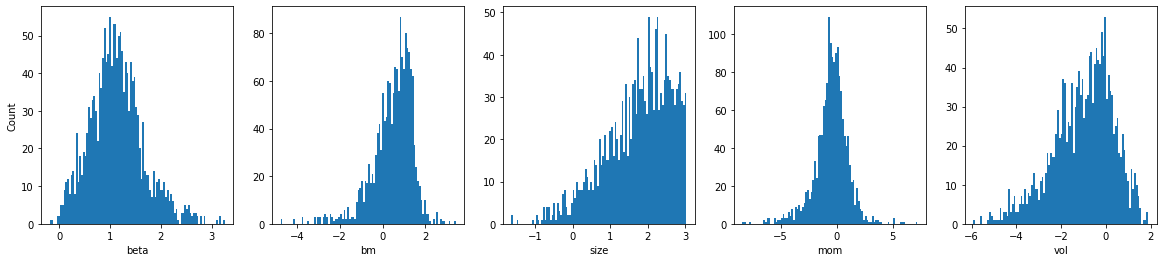

In [55]:
hw2_solution.plot_histogram(df_factors, factors)

In [57]:
res, reg_results = hw2_solution.get_regression_results(df_factors, factors)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:              logret_1m   R-squared (uncentered):                   0.634
Model:                            WLS   Adj. R-squared (uncentered):              0.633
Method:                 Least Squares   F-statistic:                              569.5
Date:                Sun, 09 Jan 2022   Prob (F-statistic):                        0.00
Time:                        22:30:21   Log-Likelihood:                          940.69
No. Observations:                1651   AIC:                                     -1871.
Df Residuals:                    1646   BIC:                                     -1844.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
beta          -0.0825      0.002    -52.238      0.000      -0.086      -0.079
bm            -0.0115      0.002     -6.513      0.000      -0.015      -0.008
size          -0.0130      0.002     -6.791      0.000      -0.017      -0.009
mom            0.0029      0.002      1.675      0.094      -0.001       0.006
vol           -0.0359      0.002    -19.476      0.000      -0.040      -0.032
==============================================================================
Omnibus:                      612.988   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25650.616
Skew:                           1.012   Prob(JB):                         0.00
Kurtosis:                      22.204   Cond. No.                         1.81
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results seen here correspond to monthly returns of Feb 2021 using factor exposures as of end of Jan 2021. We see that beta factor return, i.e. the market return was -8%. The value return was -1%, size return was -1.3%, momentum return was 0.3% and volatility return was -3.6%. So not a very typical month, but that's the way it is. All factors, but momentum were highly significant in explaining the cross-section.

### v

Compute a scatter plots between stock returns and each factor exposure for Feb 2020, Mar 2020, and Apr 2020. Plot a line representing the Value factor return (i.e. a line with the factor return as a slope). Was the stock market reaction to COVID-19 consistent through March and April?

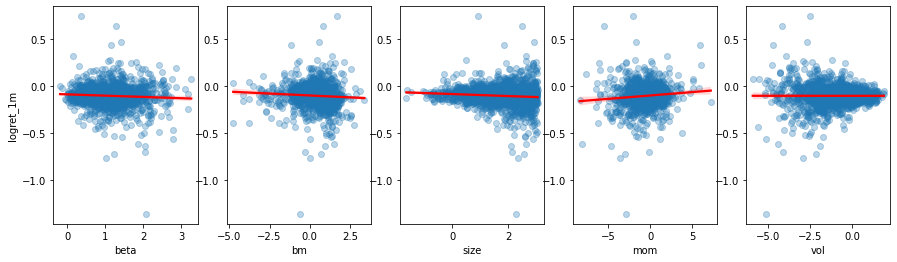

In [59]:
hw2_solution.plot_scatter(datetime(2020, 1, 31), sql)

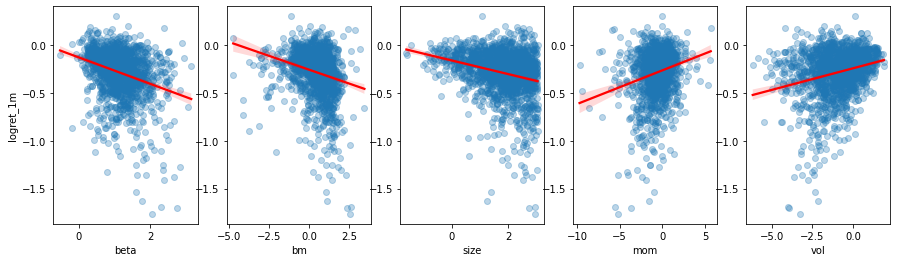

In [60]:
hw2_solution.plot_scatter(datetime(2020, 2, 28), sql)

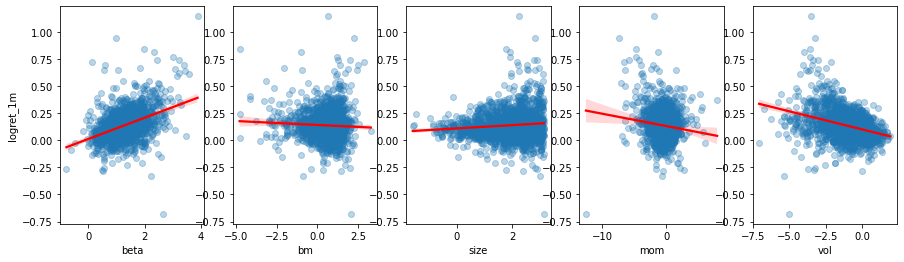

In [61]:
hw2_solution.plot_scatter(datetime(2020, 3, 31), sql)

(Remember size and vol factor exposures had their signs flipped)

We can see there was a very strong reaction in the stock market to the news of the pandemic, and the consequences were not only seen in beta, but on all factors. Companies with a higher beta did worst (obviously because the market collapsed), high value stocks did worse, small stocks did worse, low momentum stocks did worse, and high volatility stocks did worse. You can also imagine how this effect compounds for a small, high beta, low momentum, high volatility stock, and get a sense of the increased risk of holding a material quantity of one of this. We can also see that the signs of factor returns was not consistent for the next month after the collapse. The market return (beta factor return) was now positive (and high), size return now is positive (small stocks recovered a bit), momentum return now was negative (high momentum stocks now did worse), and vol return was negative (now low vol stocks did worse). All in all, we can see that stocks do indeed follow some factor-related dynamics, and those are not consistent through consecutive periods.


### vi

What Fama and French mean is that this factors explain a large portion of the risk in a portfolio. Day by day (or month by month in our case) factor returns can vary significantly, even flip signs, but they tend to be very good at explaining the cross-section of returns. Having positive exposure to a factor will more often than not tend to increase the risk of a portfolio, although it depends on the correlation between factor returns. We will formalize this idea when we forecast portfolio risk in the next assignment.

## (b)


Process the data according to part (a) for all months. That is, apply transformations (if any), standardize factor exposures, and adjust the weighted mean of Beta, then run the cross-sectional regression. Store factor returns, t-stats of coefficients, and R squared (optionally you can save p-values as well). Plot cumulative factor returns. 

In [62]:
# Turn to True to clean the tables and populate them with the results
if False:
    upload_scaled_factors_and_regression_results(sql)

### i

Make a bar plot of the significance of each factor (percentage of dates the t-stat was larger than 2 in absolute value). Analyze results. What factors have been more often significant in explaining the cross-section of log returns?

Text(0.5, 0, 'Factor')

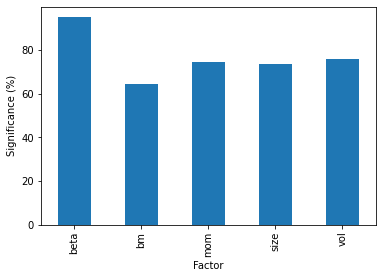

In [149]:
reg_coefs = sql.select_query('select * from reg_coefs')
tstats = reg_coefs.pivot_table(index='date', columns='factor', values='tstat')

# Plot
((tstats.abs() > 2).mean()*100).plot(kind='bar')
plt.ylabel('Significance (%)')
plt.xlabel('Factor')

### ii

Plot cumulative factor returns for all factors in one plot.  Include a verticalline where each factor was discovered/published.  What factors have had thehighest premium?  Has that changed over time?  Did publication of the resultshave any impact on factor returns going forward?

<AxesSubplot:xlabel='date'>

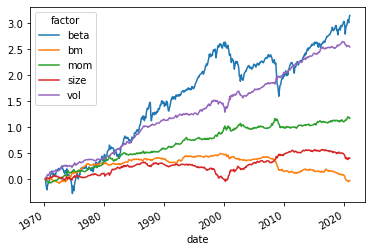

In [150]:
coefs = reg_coefs.pivot_table(index='date', columns='factor', values='coef')
coefs.cumsum().plot()

# Add lines

The rest are just validations I did

## Question 2

### a)

In [219]:
factors_sc = sql.select_query('select * from crsp_monthly_returns_factors_sc')
factors_sc['logret_1m_x_weight'] = factors_sc['logret_1m']*factors_sc['weight']
factors_sc.head()

,permno,date,ticker,logret,logret_1m,beta,bm,small,mom,lowvol,weight,logret_1m_x_weight
0,30402,1990-06-29,CAS,0.009479,-0.019047,0.791057,0.586562,2.774863,-1.169130,0.832273,0.000035,-6.695790e-07
1,20395,1990-06-29,CVB,0.000000,-0.159331,0.384555,-0.730691,2.775896,0.357852,-2.250481,0.000035,-5.592350e-06
2,61348,1990-06-29,GHX,0.024097,0.068992,0.830487,-0.599819,2.777013,3.931456,-9.020582,0.000035,2.417496e-06
3,24918,1990-06-29,FNL,0.000000,-0.011299,0.841627,0.782869,2.778738,-0.384369,-0.356824,0.000035,-3.948765e-07
4,39432,1990-06-29,GOOD,-0.025318,-0.043673,0.717618,0.879600,2.779365,-1.203543,-1.102125,0.000035,-1.524919e-06


<AxesSubplot:>

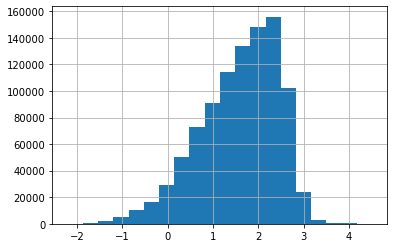

In [220]:
factors_sc.small.hist(bins=20)

In [226]:
first_cols = ['permno', 'date', 'ticker', 'logret_1m', 'logret_1m_x_weight']
factors = ['bm', 'small', 'mom', 'lowvol']
quintiles = pd.DataFrame(index=factors_sc.index, columns=first_cols + factors)
quintiles[first_cols] = factors_sc[first_cols]
for factor in factors:
    quintiles[factor] = (
        factors_sc.groupby('date')[factor]
        .transform(lambda x:
                   pd.qcut(x, [0, 0.2, 0.4, 0.6, 0.8, 1.],
                           labels=[1, 2, 3, 4, 5]))
    )

We define the factor returns based on https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html as follows:

Small factor return ($small$)
$$ small_{bm} = 1/3 (small_{bm quint=1} + small_{bm quint=3} + small_{bm quint=5}) - 1/3 (big_{bm quint=1} + big_{bm quint=3} + big_{bm quint=5}) $$
$$ small_{mom} = 1/3 (small_{mom quint=1} + small_{mom quint=3} + small_{mom quint=5}) - 1/3 (big_{mom quint=1} + big_{mom quint=3} + big_{mom quint=5})$$
$$ small_{lowvol} = 1/3 (small_{lowvol quint=1} + small_{lowvol quint=3} + small_{lowvol quint=5}) - 1/3 (big_{lowvol quint=1} + big_{lowvol quint=3} + big_{lowvol quint=5}) $$
$$ small = 1/3 (small_{bm} + small_{mom} + small_{lowvol}) $$

Bm factor return ($bm$)
$$ bm = 1/2(small_{bm quint=5} + big_{bm quint=5}) - 1/2(small_{bm quint=1} + big_{bm quint=1}) $$

Momentum factor return ($mom$)
$$ mom = 1/2(small_{mom quint=5} + big_{mom quint=5}) - 1/2(small_{mom quint=1} + big_{mom quint=1}) $$

Low vol factor return ($lowvol$)
$$ lowvol = 1/2(small_{lowvol quint=5} + big_{lowvol quint=5}) - 1/2(small_{lowvol quint=1} + big_{lowvol quint=1}) $$

In [227]:
bool_small = quintiles.small == 5
bool_big = quintiles.small == 1
for factor in ['bm', 'mom', 'lowvol']:
    col = f'group_{factor}'
    for q in [1, 3, 5]:
        quintiles.loc[bool_small & (quintiles[factor] == q), col] = f'small_{factor}{q}'
        quintiles.loc[bool_big & (quintiles[factor] == q), col] = f'big_{factor}{q}'

In [228]:
quintiles.head()

,permno,date,ticker,logret_1m,logret_1m_x_weight,bm,small,mom,lowvol,group_bm,group_mom,group_lowvol
0,30402,1990-06-29,CAS,-0.019047,-6.695790e-07,4,5,2,5,NaN,NaN,small_lowvol5
1,20395,1990-06-29,CVB,-0.159331,-5.592350e-06,1,5,4,1,small_bm1,NaN,small_lowvol1
2,61348,1990-06-29,GHX,0.068992,2.417496e-06,2,5,5,1,NaN,small_mom5,small_lowvol1
3,24918,1990-06-29,FNL,-0.011299,-3.948765e-07,4,5,3,3,NaN,small_mom3,small_lowvol3
4,39432,1990-06-29,GOOD,-0.043673,-1.524919e-06,4,5,2,2,NaN,NaN,NaN


In [229]:
def compute_group_portfolio_return(df, col):
    return df.groupby(['date', col])['logret_1m_x_weight'].sum().unstack(col)

In [230]:
df_bm = compute_group_portfolio_return(quintiles, 'group_bm')
df_mom = compute_group_portfolio_return(quintiles, 'group_mom')
df_lowvol = compute_group_portfolio_return(quintiles, 'group_lowvol')

In [231]:
small_bm = 1/3*df_bm[['small_bm1', 'small_bm3', 'small_bm5']].sum(axis=1) \
            - 1/3*df_bm[['big_bm1', 'big_bm3', 'big_bm5']].sum(axis=1)
small_mom = 1/3*df_mom[['small_mom1', 'small_mom3', 'small_mom5']].sum(axis=1) \
             - 1/3*df_mom[['big_mom1', 'big_mom3', 'big_mom5']].sum(axis=1)
small_lowvol = 1/3*df_lowvol[['small_lowvol1', 'small_lowvol3', 'small_lowvol5']].sum(axis=1) \
                - 1/3*df_lowvol[['big_lowvol1', 'big_lowvol3', 'big_lowvol5']].sum(axis=1)

In [235]:
ret_small = 1/3*(small_bm + small_mom + small_lowvol)
ret_bm = 1/2*(df_bm[['small_bm5', 'big_bm5']].sum(axis=1) - df_bm[['small_bm1', 'big_bm1']].sum(axis=1))
ret_mom = 1/2*(df_mom[['small_mom5', 'big_mom5']].sum(axis=1) - df_mom[['small_mom1', 'big_mom1']].sum(axis=1))
ret_lowvol = 1/2*(df_lowvol[['small_lowvol5', 'big_lowvol5']].sum(axis=1) - df_lowvol[['small_lowvol1', 'big_lowvol1']].sum(axis=1))

In [236]:
factors_sc

,permno,date,ticker,logret,logret_1m,beta,bm,small,mom,lowvol,weight,logret_1m_x_weight
0,30402,1990-06-29,CAS,0.009479,-0.019047,0.791057,0.586562,2.774863,-1.169130,0.832273,0.000035,-6.695790e-07
1,20395,1990-06-29,CVB,0.000000,-0.159331,0.384555,-0.730691,2.775896,0.357852,-2.250481,0.000035,-5.592350e-06
2,61348,1990-06-29,GHX,0.024097,0.068992,0.830487,-0.599819,2.777013,3.931456,-9.020582,0.000035,2.417496e-06
3,24918,1990-06-29,FNL,0.000000,-0.011299,0.841627,0.782869,2.778738,-0.384369,-0.356824,0.000035,-3.948765e-07
4,39432,1990-06-29,GOOD,-0.025318,-0.043673,0.717618,0.879600,2.779365,-1.203543,-1.102125,0.000035,-1.524919e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
959752,41371,1990-06-29,UIC,-0.014815,0.029414,1.037018,1.238075,2.765089,-2.045879,-0.567890,0.000036,1.049268e-06
959753,27800,1990-06-29,CRWN,-0.013072,-0.013245,1.023296,0.541041,2.765888,-1.285878,-1.480601,0.000036,-4.719094e-07
959754,71475,1990-06-29,SWTR,-0.012073,-0.028751,0.423880,0.777179,2.770708,0.239491,0.732157,0.000035,-1.017002e-06
959755,29145,1990-06-29,ANT,0.057820,-0.057820,1.254554,0.509746,2.771576,-2.590443,-0.625490,0.000035,-2.042610e-06


In [237]:
factors_sc['logret_1m_x_weight'] = factors_sc['logret_1m']*factors_sc['weight']
ret_mkt = factors_sc.groupby('date')['logret_1m_x_weight'].sum()

In [238]:
ts_ret = pd.concat((ret_mkt, ret_small, ret_bm, ret_mom, ret_lowvol), axis=1)
ts_ret.columns = ['mkt', 'size', 'bm', 'mom', 'vol']

In [239]:
ts_ret

,mkt,size,bm,mom,vol
date,,,,,
1970-02-27,0.001246,0.000121,0.005058,-0.004000,0.002535
1970-03-31,-0.104493,0.016680,0.014642,-0.018786,-0.023438
1970-04-30,-0.064230,0.011373,0.013255,-0.013246,-0.014099
1970-05-29,-0.052819,0.009859,0.007595,-0.011057,-0.012891
1970-06-30,0.071370,-0.011734,-0.006091,0.010235,0.020514
...,...,...,...,...,...
2020-07-31,0.067958,-0.015605,-0.020948,0.017106,0.017594
2020-08-31,-0.035596,0.007283,0.006859,-0.008036,-0.007246
2020-09-30,-0.027049,0.007553,0.010466,-0.006684,-0.008906


### b)

In [240]:
reg_coefs = sql.select_query('select * from reg_coefs')
cs_ret = reg_coefs.pivot_table(index='date', columns='factor', values='coef')
cs_ret.rename(columns={'beta': 'mkt'}, inplace=True)
factors = ['mkt', 'size', 'bm', 'mom', 'vol']
cs_ret = cs_ret[factors]

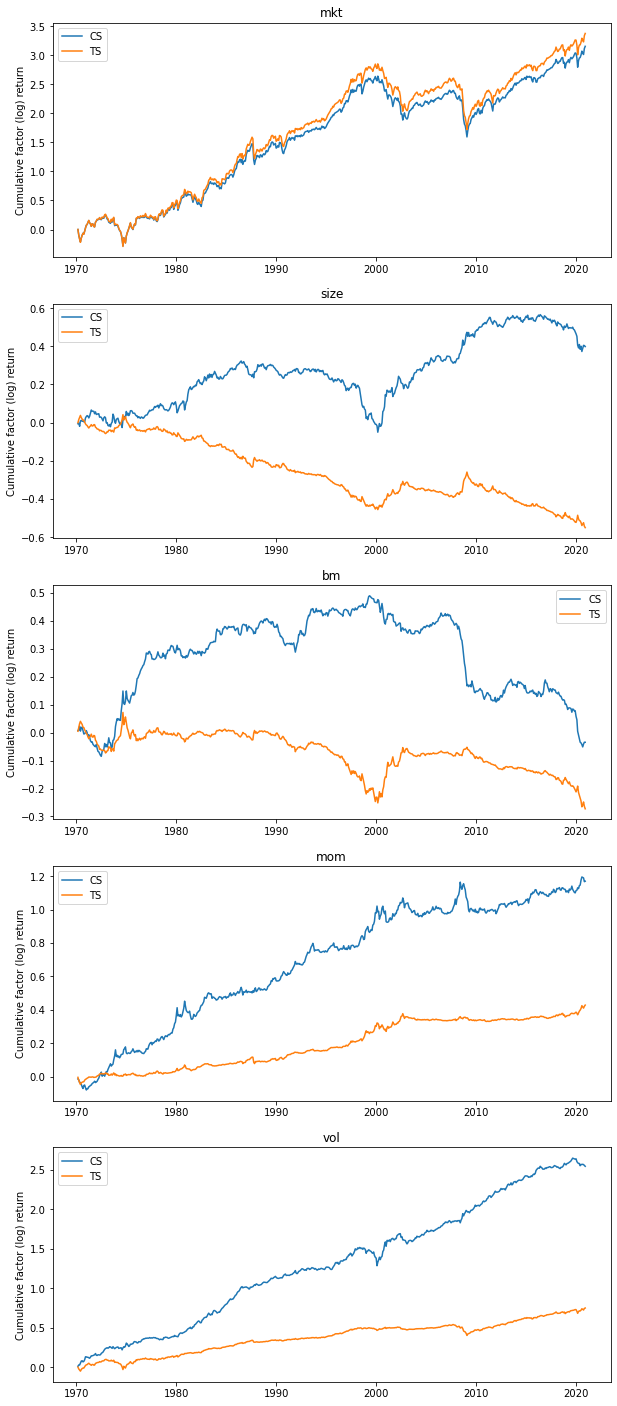

In [245]:
fig, ax = plt.subplots(len(factors), 1, figsize=(10, 5*len(factors)))
for i, factor in enumerate(factors):
    ax[i].plot(cs_ret[factor].cumsum(), label='CS')
    ax[i].plot(ts_ret[factor].cumsum(), label='TS')
    ax[i].set_title(factor)
    ax[i].set_ylabel('Cumulative factor (log) return')
    ax[i].legend()

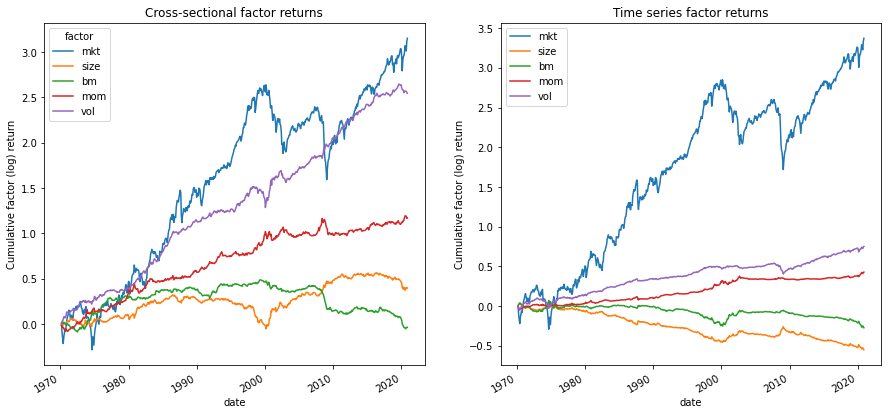

In [247]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Cross-sectional
cs_ret.cumsum().plot(ax=ax1)
ax1.set_title('Cross-sectional factor returns')
ax1.set_ylabel('Cumulative factor (log) return')

# Time series
ts_ret.cumsum().plot(ax=ax2);
ax2.set_title('Time series factor returns')
ax2.set_ylabel('Cumulative factor (log) return');

In [313]:
(cs_ret*100*12).describe()

factor,mkt,size,bm,mom,vol
count,610.000000,610.000000,610.000000,610.000000,610.000000
mean,6.201367,0.784348,-0.067613,2.302274,5.006152
std,53.000301,14.649199,12.022490,16.055948,17.292090
min,-302.887616,-55.850912,-53.790246,-76.222499,-115.907989
25%,-21.444294,-7.861643,-6.012211,-5.529219,-4.011683
50%,10.430066,1.161975,-0.222233,3.357289,4.877286
75%,40.096816,8.949225,5.883482,10.858332,15.367611
max,171.384363,76.226638,53.552105,64.683167,88.040770


In [314]:
(ts_ret*100*12).describe()

,mkt,size,bm,mom,vol
count,610.000000,610.000000,610.000000,610.000000,610.000000
mean,6.637000,-1.082042,-0.536092,0.843046,1.477693
std,55.580872,8.625293,8.704574,6.105959,8.541816
min,-312.780847,-33.450366,-52.675425,-36.067052,-40.431189
25%,-22.442731,-6.341087,-4.173284,-1.410640,-2.056216
50%,12.214430,-1.761293,-0.792513,0.796601,1.733237
75%,42.202295,3.257141,2.683996,3.253228,5.504464
max,182.160800,42.257774,48.528843,26.027992,49.801817



Cumulative market returns was the same for both methods as expected (some minor numerical approximations here only). The rest of the factor returns are different. Qualitatively, volatility and momentum had the first and second highest cumulative return (after the market) with both methodologies, but the actual cumulative numbers are different. B/M and Size were weak factors in the cross-sectional approach, while in the time series approach we see a negative cumulative factor return.

Both methodologies are quite evidently different. The level of cumulative factor returns for the cross-sectional approach depends heavily on how we standardize. The interpretation is going to be therefore different as well.


### c) 

Assuming no market frictions, how could you build a portfolio that will lock a specif factor return (say Value or Low Vol) according to the Fama-French approach? Is the original factor return computation neutralized? I.e., would that portfolio also have exposure to other factors?

Fama french based factor returns are based on a long-short portfolio, and thus reconstructing the portfolio will result in obtaining the factor return as the portfolio return. In the case of Value for instance the factor return is defined as follows

$$ bm = 1/2(small_{bm quint=5} + big_{bm quint=5}) - 1/2(small_{bm quint=1} + big_{bm quint=1}) $$

And thus the portfolio is composed of a long and a short portfolio. 

The long portfolio is equally weighted between
- A value weighted portfolio of stocks that are in the lowest quintile by size and the highest quintile by B/M.
- A value weighted portfolio of stocks that are in the highest quintile by size and the highest quintile by B/M.

The short portfolio is equally weighted between
- A value weighted portfolio of stocks that are in the lowest quintile by size and the lowest quintile by B/M.
- A value weighted portfolio of stocks that are in the highest quintile by size and the lowest quintile by B/M.

The portfolio is not neutralized by Momentum or Low Vol, or even necesarilly by Beta for that matter. Hence, it is potentially exposed to other factors.

### d)

In [269]:
df_ibm = factors_sc.loc[factors_sc.ticker == 'AAPL'].sort_values('date')
df_ibm.head()

,permno,date,ticker,logret,logret_1m,beta,bm,small,mom,lowvol,weight,logret_1m_x_weight
873614,14593,1985-11-29,AAPL,0.006231,0.105983,1.523163,-0.419052,0.599787,-2.977946,-3.424576,0.000731,0.000077
875198,14593,1985-12-31,AAPL,-0.011300,0.049874,1.522403,-0.279795,0.570745,-3.245938,-3.379924,0.000771,0.000038
876776,14593,1986-01-31,AAPL,0.005420,0.077961,1.466420,-0.277198,0.540329,-2.759814,-3.373946,0.000805,0.000063
878358,14593,1986-02-28,AAPL,-0.024692,0.122217,1.452467,-0.496750,0.539493,-1.683651,-3.337258,0.000810,0.000099
879912,14593,1986-03-31,AAPL,0.000000,0.068402,1.535422,-0.477045,0.480167,-0.826623,-3.329738,0.000887,0.000061


In [270]:
ts_ret.head()

,mkt,size,bm,mom,vol
date,,,,,
1970-02-27,0.001246,0.000121,0.005058,-0.004000,0.002535
1970-03-31,-0.104493,0.016680,0.014642,-0.018786,-0.023438
1970-04-30,-0.064230,0.011373,0.013255,-0.013246,-0.014099
1970-05-29,-0.052819,0.009859,0.007595,-0.011057,-0.012891
1970-06-30,0.071370,-0.011734,-0.006091,0.010235,0.020514


In [271]:
df_ibm = df_ibm[['permno', 'date', 'ticker', 'logret_1m', 'weight']].merge(ts_ret, how='inner', left_on=['date'], right_on=['date'])
df_ibm.head()

,permno,date,ticker,logret_1m,weight,mkt,size,bm,mom,vol
0,14593,1985-11-29,AAPL,0.105983,0.000731,0.034636,-0.005449,-0.003444,-0.000971,0.007375
1,14593,1985-12-31,AAPL,0.049874,0.000771,0.007313,0.000283,0.001517,0.001060,-0.001582
2,14593,1986-01-31,AAPL,0.077961,0.000805,0.073333,-0.010768,-0.001236,0.004113,0.007565
3,14593,1986-02-28,AAPL,0.122217,0.000810,0.050847,-0.006605,-0.002736,0.003877,0.004762
4,14593,1986-03-31,AAPL,0.068402,0.000887,-0.012686,0.002720,-0.004328,-0.002154,0.000330


In [272]:
y = df_ibm.logret_1m
x = df_ibm[factors]
w = df_ibm.weight
model = sm.WLS(y, x, weights=w)
res = model.fit()

In [280]:
from statsmodels.regression.rolling import RollingWLS

In [282]:
rols = RollingWLS(y, x, window=12*5, weights=w)
rres = rols.fit()

In [286]:
df_ibm

,permno,date,ticker,logret_1m,weight,mkt,size,bm,mom,vol
0,14593,1985-11-29,AAPL,0.105983,0.000731,0.034636,-0.005449,-0.003444,-0.000971,0.007375
1,14593,1985-12-31,AAPL,0.049874,0.000771,0.007313,0.000283,0.001517,0.001060,-0.001582
2,14593,1986-01-31,AAPL,0.077961,0.000805,0.073333,-0.010768,-0.001236,0.004113,0.007565
3,14593,1986-02-28,AAPL,0.122217,0.000810,0.050847,-0.006605,-0.002736,0.003877,0.004762
4,14593,1986-03-31,AAPL,0.068402,0.000887,-0.012686,0.002720,-0.004328,-0.002154,0.000330
...,...,...,...,...,...,...,...,...,...,...
415,14593,2020-06-30,AAPL,0.053269,0.054078,0.046524,-0.008832,-0.011321,0.009518,0.010957
416,14593,2020-07-31,AAPL,0.196077,0.058999,0.067958,-0.015605,-0.020948,0.017106,0.017594
417,14593,2020-09-30,AAPL,-0.061888,0.061919,-0.027049,0.007553,0.010466,-0.006684,-0.008906
418,14593,2020-10-30,AAPL,0.091207,0.059675,0.107143,-0.018510,-0.015453,0.010983,0.020570


In [291]:
factor_exp_ibm = df_ibm[['permno', 'date', 'ticker', 'logret_1m']].join(rres.params)
factor_exp_ibm.tail()

,permno,date,ticker,logret_1m,mkt,size,bm,mom,vol
415,14593,2020-06-30,AAPL,0.053269,2.445067,11.390693,-12.786278,-4.344522,-4.110920
416,14593,2020-07-31,AAPL,0.196077,1.308903,4.083487,-12.900912,-3.870212,-4.395385
417,14593,2020-09-30,AAPL,-0.061888,1.467801,5.147520,-12.868777,-3.692399,-4.399488
418,14593,2020-10-30,AAPL,0.091207,1.710881,7.126773,-12.814967,-2.865034,-4.653623
419,14593,2020-11-30,AAPL,0.116203,1.640410,6.245699,-12.759787,-2.712452,-5.044088


<AxesSubplot:>

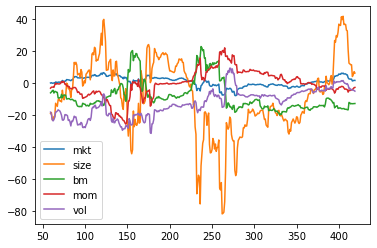

In [295]:
factor_exp_ibm[factors].plot()

<AxesSubplot:xlabel='date'>

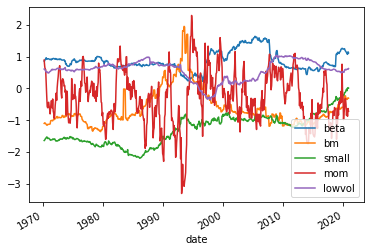

In [318]:
(factors_sc.loc[factors_sc.ticker == 'IBM', 
               ['date', 'beta', 'bm', 'small', 'mom', 'lowvol']]
           .sort_values('date')
           .set_index('date')
           .plot())

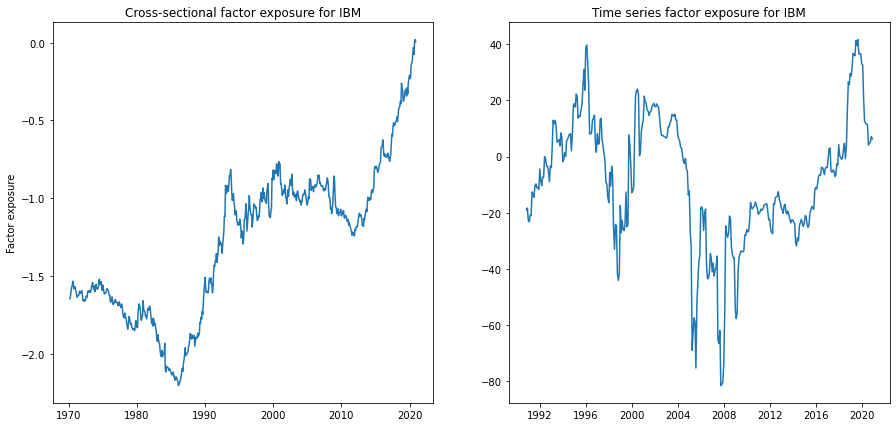

In [312]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Cross-sectional
cs_plot = factors_sc.loc[factors_sc.ticker == 'IBM', ['date', 'small']].sort_values('date').set_index('date')
ax1.plot(cs_plot)
ax1.set_title('Cross-sectional factor exposure for IBM')
ax1.set_ylabel('Factor exposure')

# Time series
ts_plot = factor_exp_ibm[['date', 'size']].sort_values('date').set_index('date')
ax2.plot(ts_plot)
ax2.set_title('Time series factor exposure for IBM')

plt.show()

IBM has had quite a ride. In the cross-sectional space, it started in the 1970s with a low size factor exposure (meaning it was a large company) and it became larger and larger up until around 1986. Let's remember IBM was the leading technology firm, with top-notch PCs at the time. At one point it even developed Deep Blue which beat the chess world champion Gary Kasparov, very much how Google did many years later with Alpha Go. Thereafter it downsized quite aggresively, stayed constant for a while, and now more recently it has decreased its market cap relative to the other companies. 

This very clean story is quite messy when looking at the factor exposures given by the factor returns from the Fama French factor. For starters the factor returns had the opposite risk premium to what we would have expected. And factor exposures for IBM are very wobbly. Given that the Fama French approach uses a rolling regression to compute the factor exposure it takes longer to react to sizing events. We can also see it is unstable, and reacts too much to events unrelated to their size (probably noise coming from the computation of factor returns which involves an attempt to neutralize the effect of size with other factors). All in all, the cross-sectional approach yields cleaner, more reasonable, and easier to interpret results.